Oscilador de Duffing

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from powerlaw import Fit
import sys
sys.path.append("/home/jj/time-series-to-complex-networks")
from src.network_construction.entropia_grafo import (
    crear_ind,
    crear_grafo,
    calcular_entropia,
    optimizar_w
)


In [3]:
import os

base = "/home/jj/time-series-to-complex-networks/results/networks"

nodos = {}
edges = {}
otros = {}

for f in os.listdir(base):
    if not f.endswith(".npy"):
        continue
    
    full_path = os.path.join(base, f)
    arr = np.load(full_path, allow_pickle=True)

    fname = f.lower()

    # --- FILTRO DUFFING ---
    if "kuramoto" in fname and "nodos" in fname:
        nodos[f] = arr
    
    elif "kuramoto" in fname and "edges" in fname:
        edges[f] = arr

    else:
        otros[f] = arr

print("\nArchivos kuramoto_nodos:", list(nodos.keys()))
print("Archivos kuramoto_edges:", list(edges.keys()))
print("Otros archivos:", list(otros.keys()))



Archivos kuramoto_nodos: ['Kuramoto_class_quant_nodos.npy', 'Kuramoto_quant_quant_nodos.npy', 'Kuramoto_class_class_nodos.npy', 'Kuramoto_quant_class_nodos.npy']
Archivos kuramoto_edges: ['kuramoto_quant_quant_edges.npy', 'kuramoto_quant_class_edges.npy', 'kuramoto_class_quant_edges.npy', 'kuramoto_class_class_edges.npy']
Otros archivos: ['duffing_quant_quant_edges.npy', 'duffing_class_class_nodos.npy', 'duffing_class_quant_entropy.npy', 'kuramoto_quant_quant_entropy.npy', 'duffing_class_quant_edges.npy', 'duffing_quant_class_nodos.npy', 'kuramoto_class_class_entropy.npy', 'duffing_class_class_entropy.npy', 'kuramoto_quant_class_entropy.npy', 'kuramoto_class_quant_entropy.npy', 'duffing_class_class_edges.npy', 'duffing_class_quant_nodos.npy', 'duffing_quant_quant_nodos.npy', 'duffing_quant_class_entropy.npy', 'duffing_quant_quant_entropy.npy', 'duffing_quant_class_edges.npy']


In [5]:
clas = pd.read_csv('/home/jj/time-series-to-complex-networks/data/generated/kuramoto_class_timeseries.csv')
quant = pd.read_csv('/home/jj/time-series-to-complex-networks/data/generated/kuramoto_quant_timeseries.csv')

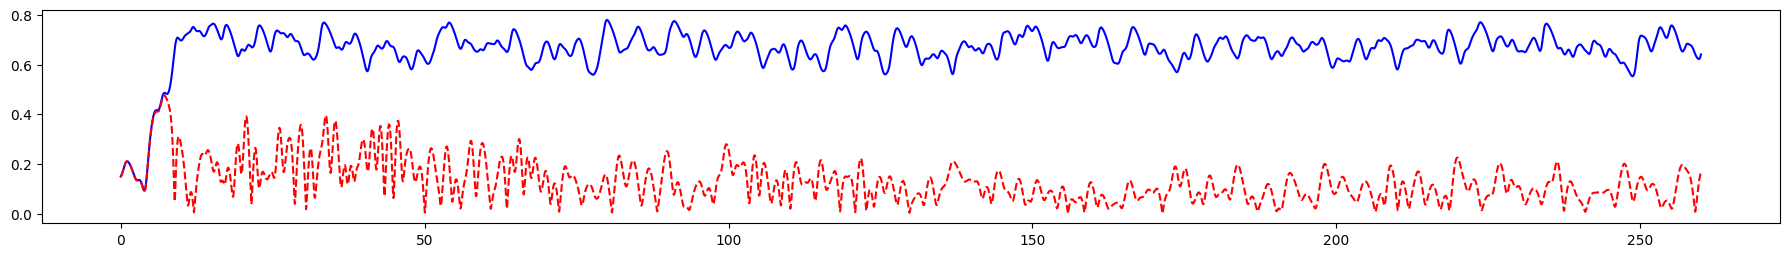

In [8]:
plt.figure(figsize=(18,10))

plt.subplot(4, 1, 1)
plt.plot(clas['t'], clas['r'], label="x", color="blue")
plt.plot(quant['t'], quant['r'], label= '<x>', color= 'red',linestyle='--')

plt.tight_layout()
plt.show()

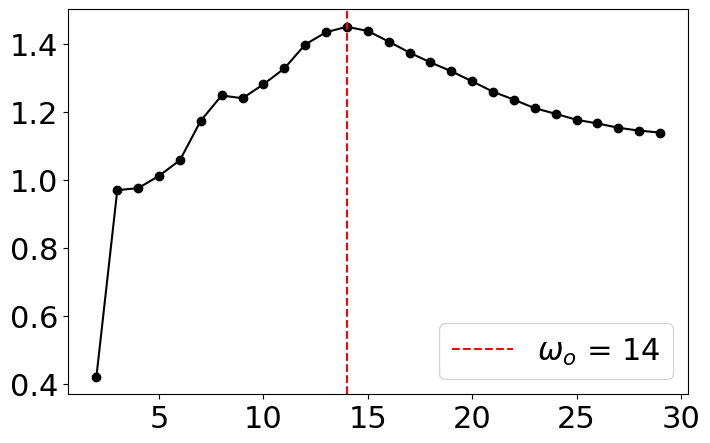

El w clásico óptimo es: 14


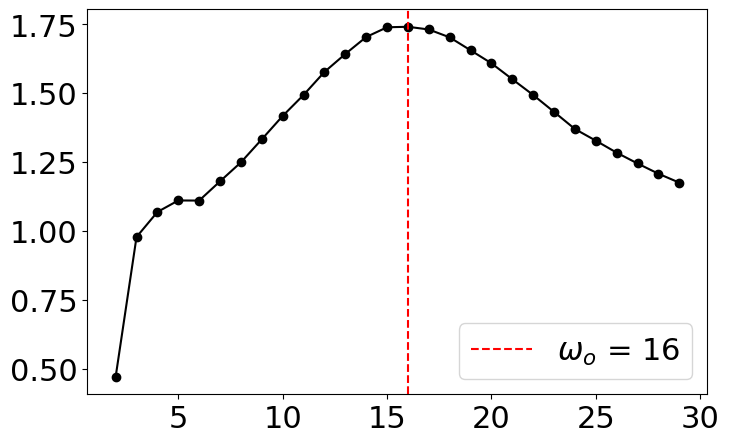

El w cuántico óptimo es: 16


In [9]:
w_opt1 = optimizar_w(clas['r'], w_min=2, w_max=30)
print(f"El w clásico óptimo es: {w_opt1}") 

w_opt2 = optimizar_w(quant['r'], w_min=2, w_max=30)
print(f"El w cuántico óptimo es: {w_opt2}") 

In [10]:
G11 = nx.Graph() ### Serie clásica con w_opt clásico
G21 = nx.Graph() ### Serie cuántica con w_opt clásico
G12 = nx.Graph() ### Serie clásica con w_opt cuántico
G22 = nx.Graph() ### Serie cuántica con w_opt cuántica

for edge in edges['kuramoto_class_class_edges.npy']:
    i, j = edge
    G11.add_edge(int(i), int(j))
for edge in edges['kuramoto_quant_class_edges.npy']:
    i, j = edge
    G21.add_edge(int(i), int(j))
for edge in edges['kuramoto_class_quant_edges.npy']:
    i, j = edge
    G12.add_edge(int(i), int(j))
for edge in edges['kuramoto_quant_quant_edges.npy']:
    i, j = edge
    G22.add_edge(int(i), int(j))

grafos = [G11, G12, G21, G22]
titulos = [
    "Serie clásica con w_opt clásico",
    "Serie cuántica con w_opt clásico",
    "Serie clásica con w_opt cuántico",
    "Serie cuántica con w_opt cuántica"
]

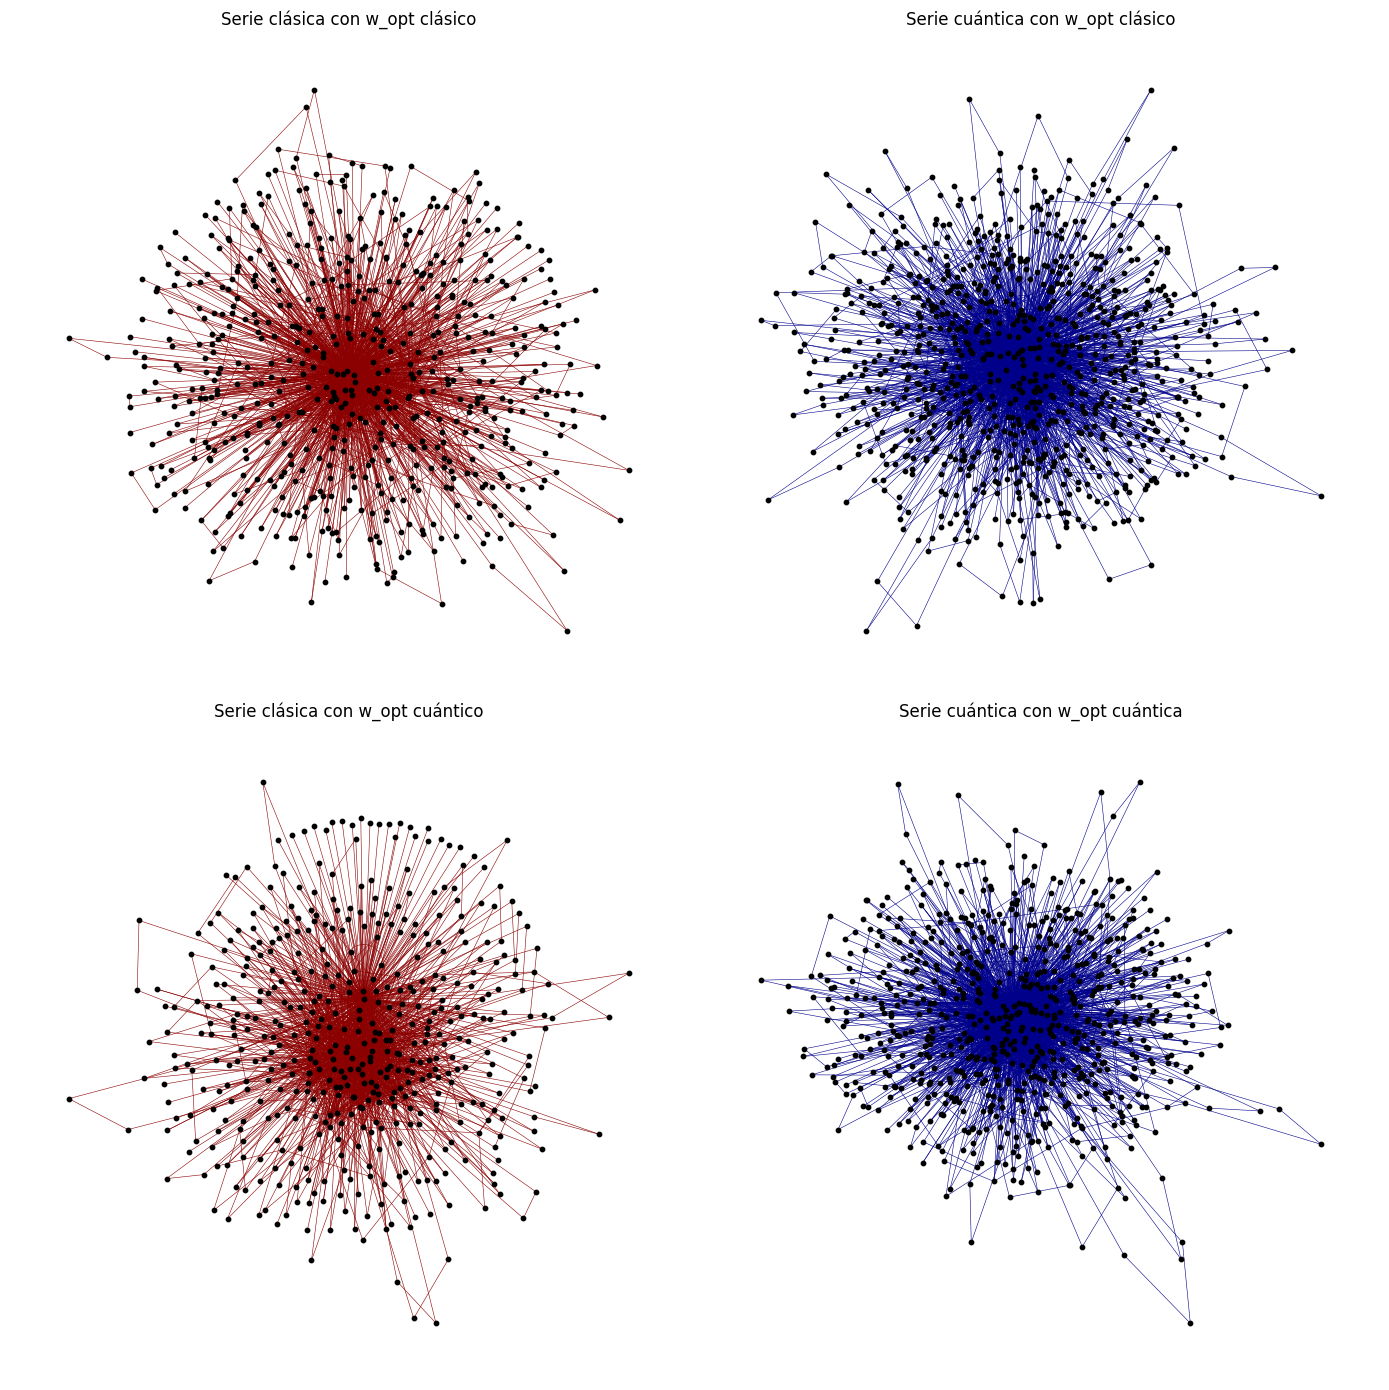

In [11]:
plt.figure(figsize=(14, 14))

for i, G in enumerate(grafos):
    plt.subplot(2, 2, i+1)
    pos = nx.spring_layout(G, seed=42)

    # Redes de la izquierda → darkred
    if i in [0, 2]:  # posiciones 1 y 3
        node_color = "black"
        edge_color = "darkred"
    else:  # posiciones 2 y 4 → colores originales
        node_color = "black"
        edge_color = "darkblue"

    nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_color)
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, width=0.4)

    plt.title(titulos[i], fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

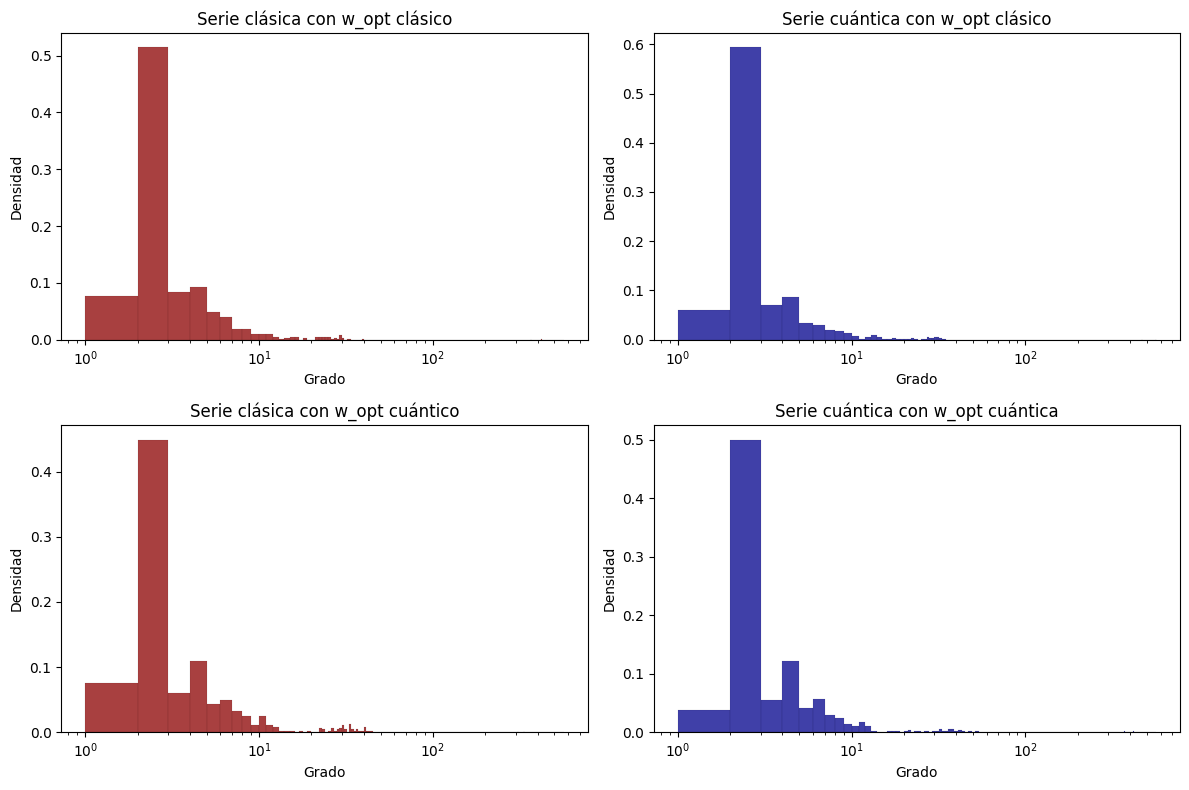

In [12]:


all_degrees = []
for G in grafos:
    all_degrees.extend([d for _, d in G.degree()])

min_degree = min(all_degrees)
max_degree = max(all_degrees)

bins = np.arange(min_degree, max_degree + 2, 1)


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, G in enumerate(grafos):

    row = i // 2
    col = i % 2

    ax = axes[row, col]

    degrees = [d for _, d in G.degree()]

    color = "darkred" if col == 0 else "darkblue"

    sns.histplot(degrees, bins=bins, stat='density', color=color, ax=ax)

    ax.set_xscale("log")
    ax.set_title(titulos[i], fontsize=12)
    ax.set_ylabel("Densidad")
    ax.set_xlabel("Grado")

plt.tight_layout()
plt.show()



In [13]:
rows = []

for name, G in zip(titulos, grafos):

    degrees = [d for _, d in G.degree()]
    avg_degree = np.mean(degrees)
    triangles = sum(nx.triangles(G).values()) // 3

    # Métricas de conectividad (solo para componente principal si es necesario)
    try:
        diameter = nx.diameter(G)
        avg_path = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        # Limitar las métricas al componente gigante
        GC = max(nx.connected_components(G), key=len)
        Gc = G.subgraph(GC)
        try:
            diameter = nx.diameter(Gc)
            avg_path = nx.average_shortest_path_length(Gc)
        except:
            diameter = None
            avg_path = None

    # Ley de potencia
    try:
        fit = Fit(degrees, verbose=False)
        alpha = fit.power_law.alpha
        xmin = fit.power_law.xmin
        R, p = fit.distribution_compare('power_law', 'exponential')
    except Exception as e:
        alpha = None
        xmin = None
        R = None
        p = None

    row = {
        "Red": name,
        "N nodos": G.number_of_nodes(),
        "N edges": G.number_of_edges(),
        "Grado medio": avg_degree,
        "Diámetro": diameter,
        "Clustering": nx.average_clustering(G),
        "Path length medio": avg_path,
        "Densidad": nx.density(G),
        "Asortatividad": nx.degree_assortativity_coefficient(G),
        "Triángulos": triangles,
        "alpha (power-law)": alpha,
        "xmin (power-law)": xmin,
        "R PL vs EXP": R,
        "p PL vs EXP": p
    }

    rows.append(row)

tabla = pd.DataFrame(rows)
print(tabla)


                                 Red  N nodos  N edges  Grado medio  Diámetro  \
0    Serie clásica con w_opt clásico      587     1697     5.781942         4   
1   Serie cuántica con w_opt clásico      864     2255     5.219907         4   
2   Serie clásica con w_opt cuántico      488     1816     7.442623         4   
3  Serie cuántica con w_opt cuántica      726     2556     7.041322         6   

   Clustering  Path length medio  Densidad  Asortatividad  Triángulos  \
0    0.593879           2.268002  0.009867      -0.332322        1588   
1    0.528404           2.419258  0.006049      -0.315581        1824   
2    0.474884           2.298280  0.015283      -0.286710        2202   
3    0.436329           2.494644  0.009712      -0.245566        2721   

   alpha (power-law)  xmin (power-law)  R PL vs EXP   p PL vs EXP  
0           2.497563               4.0   116.848949  8.047495e-03  
1           2.563369               4.0   163.742438  6.828293e-03  
2           2.431394    

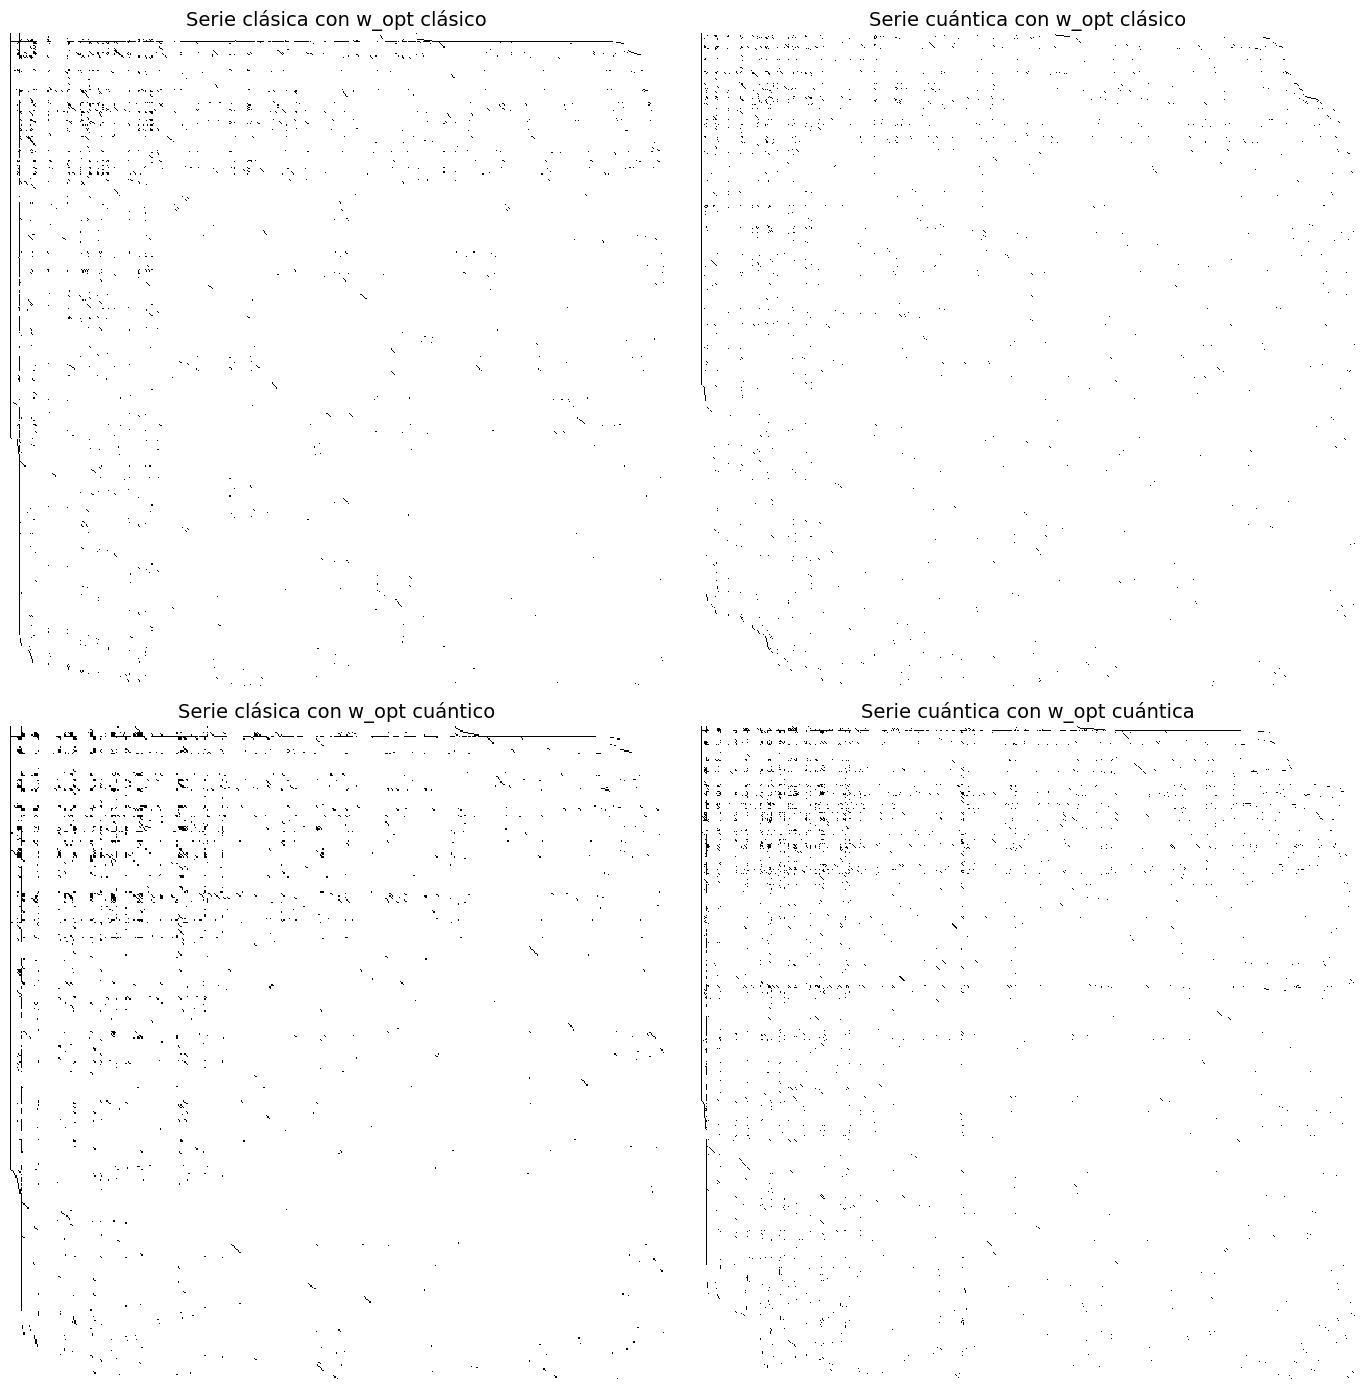

In [14]:
plt.figure(figsize=(14, 14))

for i, (G, title) in enumerate(zip(grafos, titulos)):
    plt.subplot(2, 2, i+1)

    A = nx.adjacency_matrix(G).toarray()

    plt.imshow(A, cmap='gray_r', interpolation='nearest')
    plt.title(title, fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
nodos_class_class = nodos['Kuramoto_class_class_nodos.npy'].item()
nodos_quant_class = nodos['Kuramoto_quant_class_nodos.npy'].item()
nodos_class_quant = nodos['Kuramoto_class_quant_nodos.npy'].item()
nodos_quant_quant = nodos['Kuramoto_quant_quant_nodos.npy'].item()

In [18]:
def ordenar_arista(u, v):
    return tuple(sorted((u, v)))

def edges_normalizadas(G, nodemap):
    edges = []
    for u, v in G.edges():
        u2 = nodemap[u]
        v2 = nodemap[v]
        edges.append(ordenar_arista(u2, v2))
    return edges

def nodos_from_edges(lista_aristas):
    nodos = set()
    for u, v in lista_aristas:
        nodos.add(u)
        nodos.add(v)
    return nodos


In [19]:
edges_G11 = edges_normalizadas(G11, nodos_class_class)
edges_G21 = edges_normalizadas(G21, nodos_quant_class)

edges_G12 = edges_normalizadas(G12, nodos_class_quant)
edges_G22 = edges_normalizadas(G22, nodos_quant_quant)

set11 = set(edges_G11)
set21 = set(edges_G21)

union_11_21       = list(set11 | set21)
intersect_11_21   = list(set11 & set21)
only_G11          = list(set11 - set21)
only_G21          = list(set21 - set11)

set12 = set(edges_G12)
set22 = set(edges_G22)

union_12_22       = list(set12 | set22)
intersect_12_22   = list(set12 & set22)
only_G12          = list(set12 - set22)
only_G22          = list(set22 - set12)


nodes_only_G11     = nodos_from_edges(set11) - nodos_from_edges(set21)
nodes_only_G21     = nodos_from_edges(set21) - nodos_from_edges(set11)
nodes_intersect_11_21  = nodos_from_edges(set11) & nodos_from_edges(set21)

nodes_only_G12     = nodos_from_edges(set12) - nodos_from_edges(set22)
nodes_only_G22     = nodos_from_edges(set22) - nodos_from_edges(set12)
nodes_intersect_12_22  = nodos_from_edges(set12) & nodos_from_edges(set22)

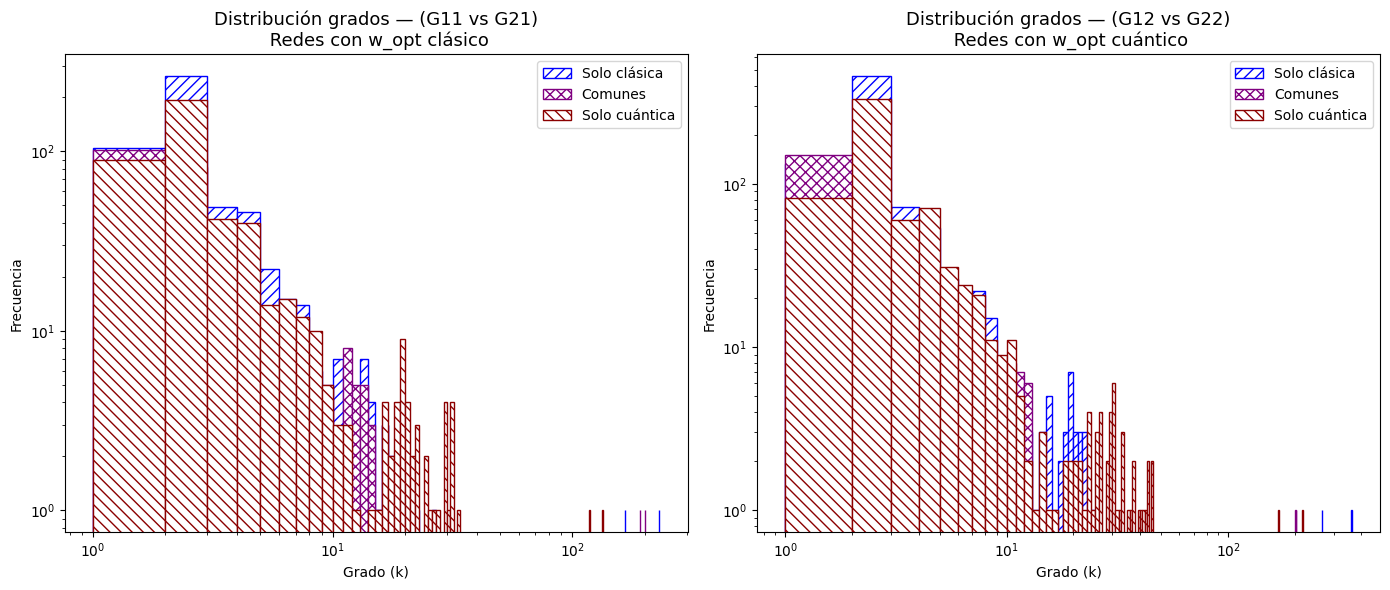

In [20]:
def plot_distribucion(edges_only_A, edges_common, edges_only_B, title):
    """
    Genera UNA gráfica de distribuciones de grado para:
    - Solo A
    - Comunes
    - Solo B
    """
    # Construir grafos parciales
    GA = nx.Graph(); GA.add_edges_from(edges_only_A)
    GB = nx.Graph(); GB.add_edges_from(edges_only_B)
    GC = nx.Graph(); GC.add_edges_from(edges_common)

    deg_A = [d for _, d in GA.degree()]
    deg_B = [d for _, d in GB.degree()]
    deg_C = [d for _, d in GC.degree()]

    all_degs = deg_A + deg_B + deg_C
    if len(all_degs) == 0:
        print(f"No hay grados en {title}")
        return

    # Bins comunes
    max_degree = max(all_degs)
    bins = np.arange(1, max_degree + 1)

    plt.hist(deg_A, bins=bins, facecolor='white', edgecolor='blue',
             hatch='///', alpha=1, label="Solo clásica")

    plt.hist(deg_C, bins=bins, facecolor='white', edgecolor='purple',
             hatch='XXX', alpha=1, label="Comunes")

    plt.hist(deg_B, bins=bins, facecolor='white', edgecolor='darkred',
             hatch='\\\\\\', alpha=1, label="Solo cuántica")

    plt.xscale('log')
    plt.yscale('log')
    plt.title(title, fontsize=13)
    plt.xlabel("Grado (k)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(False)


# ========== FIGURA PRINCIPAL (DOS GRÁFICAS) ==========
plt.figure(figsize=(14, 6))

# --- PAREJA 1 (G11 vs G21) ---
plt.subplot(1, 2, 1)
plot_distribucion(
    only_G11,     # solo clásico
    intersect_11_21,       # comunes
    only_G21,     # solo cuántico
    "Distribución grados — (G11 vs G21)\n Redes con w_opt clásico"
)

# --- PAREJA 2 (G12 vs G22) ---
plt.subplot(1, 2, 2)
plot_distribucion(
    only_G12,     # solo clásico
    intersect_12_22,       # comunes
    only_G22,     # solo cuántico
    "Distribución grados — (G12 vs G22)\n Redes con w_opt cuántico"
)

plt.tight_layout()
plt.show()


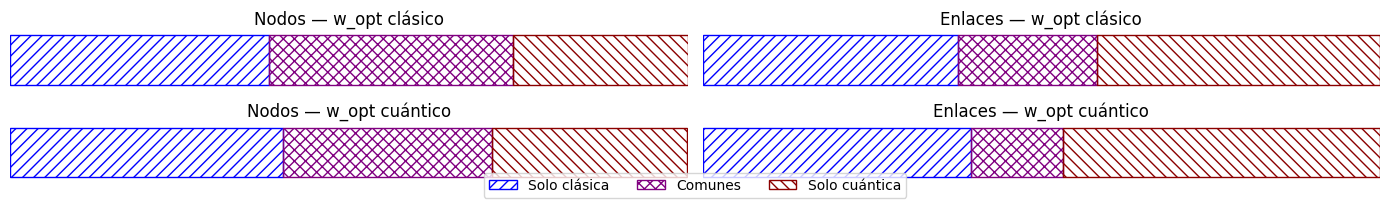

In [21]:
def venn_bar(solo_A, solo_B, inter):
    total = solo_A + solo_B + inter
    if total == 0:
        return 0, 0, 0
    return solo_A/total, inter/total, solo_B/total

def plot_bar(ax, pA, pI, pB, title):
    ax.barh(0, pA, color='none', edgecolor='blue', hatch='///', label="Solo clásica")
    ax.barh(0, pI, left=pA, color='none', edgecolor='purple', hatch='XXX', label="Comunes")
    ax.barh(0, pB, left=pA + pI, color='none', edgecolor='darkred',
            hatch='\\\\\\', label="Solo cuántica")

    ax.set_xlim(0, 1)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

solo_A_nodes_11 = len(nodes_only_G11)
solo_B_nodes_11 = len(nodes_only_G21)
inter_nodes_11  = len(nodes_intersect_11_21)

solo_A_edges_11 = len(only_G11)
solo_B_edges_11 = len(only_G21)
inter_edges_11  = len(intersect_11_21)

pA_n11, pI_n11, pB_n11 = venn_bar(solo_A_nodes_11, solo_B_nodes_11, inter_nodes_11)
pA_e11, pI_e11, pB_e11 = venn_bar(solo_A_edges_11, solo_B_edges_11, inter_edges_11)


solo_A_nodes_12 = len(nodes_only_G12)
solo_B_nodes_12 = len(nodes_only_G22)
inter_nodes_12  = len(nodes_intersect_12_22)

solo_A_edges_12 = len(only_G12)
solo_B_edges_12 = len(only_G22)
inter_edges_12  = len(intersect_12_22)

pA_n12, pI_n12, pB_n12 = venn_bar(solo_A_nodes_12, solo_B_nodes_12, inter_nodes_12)
pA_e12, pI_e12, pB_e12 = venn_bar(solo_A_edges_12, solo_B_edges_12, inter_edges_12)



fig, axs = plt.subplots(2, 2, figsize=(14, 2))

# ----------- fila superior → w_opt clásico -----------
plot_bar(axs[0, 0], pA_n11, pI_n11, pB_n11, "Nodos — w_opt clásico")
plot_bar(axs[0, 1], pA_e11, pI_e11, pB_e11, "Enlaces — w_opt clásico")

# ----------- fila inferior → w_opt cuántico ----------
plot_bar(axs[1, 0], pA_n12, pI_n12, pB_n12, "Nodos — w_opt cuántico")
plot_bar(axs[1, 1], pA_e12, pI_e12, pB_e12, "Enlaces — w_opt cuántico")


# Leyenda global
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()



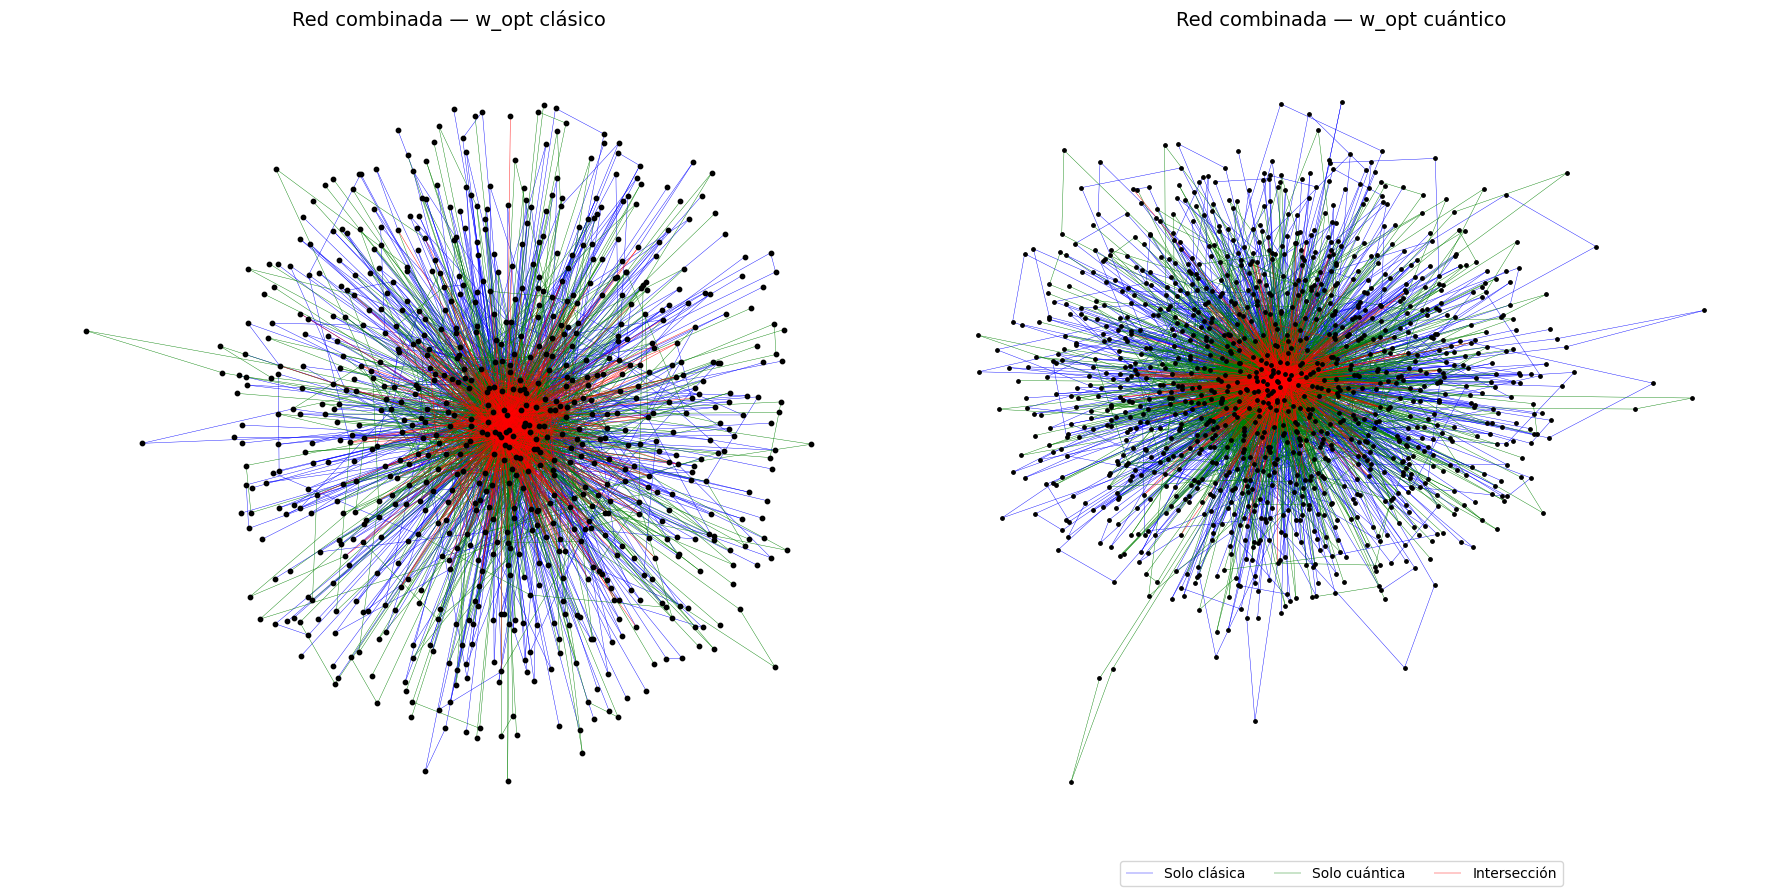

In [22]:
# --- Combinada para w_opt clásico (G11 vs G21)
G_unidos1 = nx.Graph()
G_unidos1.add_edges_from(union_11_21)

# --- Combinada para w_opt cuántico (G12 vs G22)
G_unidos2 = nx.Graph()
G_unidos2.add_edges_from(union_12_22)

plt.figure(figsize=(18, 9))

# ========= 
ax1 = plt.subplot(1, 2, 1)
pos1 = nx.spring_layout(G_unidos1, seed=42)

nx.draw_networkx_nodes(G_unidos1, pos1, node_size=10, node_color='black')

nx.draw_networkx_edges(G_unidos1, pos1,
                       edgelist=only_G11,
                       edge_color='blue',
                       width=0.3,
                       label='Solo clásica')

nx.draw_networkx_edges(G_unidos1, pos1,
                       edgelist=only_G21,
                       edge_color='green',
                       width=0.3,
                       label='Solo cuántica')

nx.draw_networkx_edges(G_unidos1, pos1,
                       edgelist=intersect_11_21,
                       edge_color='red',
                       width=0.3,
                       label='Intersección')

plt.title("Red combinada — w_opt clásico", fontsize=14)
plt.axis('off')


# ========= SUBPLOT 2 — G12 vs G22 =========
ax2 = plt.subplot(1, 2, 2)
pos2 = nx.spring_layout(G_unidos2, seed=42)

nx.draw_networkx_nodes(G_unidos2, pos2, node_size=6, node_color='black')

nx.draw_networkx_edges(G_unidos2, pos2,
                       edgelist=only_G12,
                       edge_color='blue',
                       width=0.3,
                       label='Solo clásica')

nx.draw_networkx_edges(G_unidos2, pos2,
                       edgelist=only_G22,
                       edge_color='green',
                       width=0.3,
                       label='Solo cuántica')

nx.draw_networkx_edges(G_unidos2, pos2,
                       edgelist=intersect_12_22,
                       edge_color='red',
                       width=0.3,
                       label='Intersección')

plt.title("Red combinada — w_opt cuántico", fontsize=14)
plt.axis('off')


# -------- Leyenda global --------
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0, -0.05, 1, 0))

plt.tight_layout()
plt.show()


In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def construir_red_3d(edges_gra, edges_gra1, edges_inter):

    nodos_gra = set(n for u,v in edges_gra for n in (u,v))
    nodos_gra1 = set(n for u,v in edges_gra1 for n in (u,v))

    nodos_comunes = nodos_gra & nodos_gra1
    solo_gra = nodos_gra - nodos_gra1
    solo_gra1 = nodos_gra1 - nodos_gra

    def posiciones_circulares(nodos, base_radio, z, escala='log'):
        n = max(len(nodos), 1)
        if escala == 'log':
            radio = base_radio * np.log(n + 1)
        else:
            radio = base_radio * n
        ang = 2*np.pi / n
        return {node: (radio*np.cos(i*ang),
                       radio*np.sin(i*ang),
                       z)
                for i, node in enumerate(nodos)}

    pos_gra1 = posiciones_circulares(solo_gra1, 1.2, 2)
    pos_comunes = posiciones_circulares(nodos_comunes, 1.2, 1)
    pos_gra = posiciones_circulares(solo_gra, 1.2, 0)

    pos_3d = {**pos_gra1, **pos_comunes, **pos_gra}

    def trazar_aristas_3d(edges, color, name, width):
        x,y,z = [],[],[]
        for u,v in edges:
            if u in pos_3d and v in pos_3d:
                x += [pos_3d[u][0], pos_3d[v][0], None]
                y += [pos_3d[u][1], pos_3d[v][1], None]
                z += [pos_3d[u][2], pos_3d[v][2], None]
        return go.Scatter3d(
            x=x, y=y, z=z,
            mode='lines',
            line=dict(color=color, width=width),
            name=name,
            hoverinfo='none'
        )

    trace_gra = trazar_aristas_3d(edges_gra, "blue", "solo gra", 1)
    trace_gra1 = trazar_aristas_3d(edges_gra1, "red", "solo gra1", 1)
    trace_inter = trazar_aristas_3d(edges_inter, "darkgreen", "intersección", 1)

    def trazar_nodos_3d(nodos, color, name):
        xs,ys,zs = [],[],[]
        for n in nodos:
            if n in pos_3d:
                x,y,z = pos_3d[n]
                xs.append(x); ys.append(y); zs.append(z)
        return go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode="markers",
            marker=dict(size=2, color=color),
            name=name
        )

    trace_nodos_gra = trazar_nodos_3d(solo_gra, "cornflowerblue", "nodos gra")
    trace_nodos_gra1 = trazar_nodos_3d(solo_gra1, "indianred", "nodos gra1")
    trace_nodos_comunes = trazar_nodos_3d(nodos_comunes, "darkgreen", "nodos intersección")

    return [
        trace_gra1,
        trace_gra,
        trace_inter,
        trace_nodos_gra1,
        trace_nodos_comunes,
        trace_nodos_gra
    ]

# ==================== 

traces_A = construir_red_3d(only_G11, only_G21, intersect_11_21)
traces_B = construir_red_3d(only_G12, only_G22, intersect_12_22)

# =================== 

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=("Red A — w_opt clásico", "Red B — w_opt cuántico")
)

for t in traces_A:
    fig.add_trace(t, row=1, col=1)

for t in traces_B:
    fig.add_trace(t, row=1, col=2)

fig.update_layout(
    height=700,
    width=1200,
    showlegend=True,
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False)),
    scene2=dict(xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False))
)
fig.show()


In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
import networkx as nx

def draw_curve(ax, x1, y1, x2, y2, color='black', alpha=0.6, lw=0.5, rad=0.3):
    con = FancyArrowPatch(
        (x1, y1), (x2, y2),
        connectionstyle=f"arc3,rad={rad}",
        color=color, lw=lw, alpha=alpha, arrowstyle='-'
    )
    ax.add_patch(con)

def ordenar_arista(u, v):
    return tuple(sorted((u, v)))

# ============================================================

def plot_comunidades_matriz(
    nodos_comunes,
    solo_gra,
    solo_gra1,
    G_unidos,
    edges_only_gra=set(),
    edges_only_gra1=set(),
    nodos_intersection=set()
):

    comunidades_1 = {
        0: list(nodos_comunes),
        1: list(solo_gra),
        2: list(solo_gra1)
    }

    partition_global = {
        **{n: 0 for n in nodos_comunes},
        **{n: 1 for n in solo_gra},
        **{n: 2 for n in solo_gra1}
    }

    set_inter = set(nodos_intersection)
    set_only_gra = set(edges_only_gra)
    set_only_gra1 = set(edges_only_gra1)

    matrices = [0]
    redes = [1, 2]

    fig, ax = plt.subplots(figsize=(14, 14))
    size_celda = 0.17
    posiciones = {}

    # ============================================================
    # MATRIZ CENTRAL
    com_id = 0
    nodos_original = comunidades_1[com_id]

    grupo_azul, grupo_morado, grupo_rojo = [], [], []

    for nodo in nodos_original:
        vecinos = list(G_unidos.neighbors(nodo))
        tipo_conexiones = set()
        for v in vecinos:
            if partition_global[v] != com_id:
                edge = ordenar_arista(nodo, v)
                if edge in set_inter:
                    tipo_conexiones.add('inter')
                elif edge in set_only_gra:
                    tipo_conexiones.add('gra')
                elif edge in set_only_gra1:
                    tipo_conexiones.add('gra1')

        if 'inter' in tipo_conexiones:
            grupo_morado.append(nodo)
        elif 'gra' in tipo_conexiones:
            grupo_azul.append(nodo)
        elif 'gra1' in tipo_conexiones:
            grupo_rojo.append(nodo)
        else:
            grupo_morado.append(nodo)

    nodos = grupo_azul + grupo_morado + grupo_rojo
    n = len(nodos)
    subG = G_unidos.subgraph(nodos)
    nodo_idx = {nodo: idx for idx, nodo in enumerate(nodos)}

    x_centro = y_centro = 0
    offset_x = x_centro - (n * size_celda) / 2
    offset_y = y_centro - (n * size_celda) / 2

    # Dibujar matriz
    for u, v in subG.edges():
        i, j = nodo_idx[u], nodo_idx[v]
        edge = ordenar_arista(u, v)

        if edge in set_inter:
            color = 'purple'
        elif edge in set_only_gra:
            color = 'darkblue'
        elif edge in set_only_gra1:
            color = 'darkred'
        else:
            color = 'black'

        for row, col in [(i, j), (j, i)]:
            ax.add_patch(plt.Rectangle(
                (offset_x + col * size_celda, offset_y + (n - row - 1) * size_celda),
                size_celda, size_celda,
                facecolor=color, edgecolor='none'
            ))

    ax.add_patch(plt.Rectangle(
        (offset_x, offset_y),
        n * size_celda, n * size_celda,
        fill=False, edgecolor='black', linewidth=0.5
    ))

    for idx, nodo in enumerate(nodos):
        y = offset_y + (n - idx - 0.5) * size_celda
        posiciones[(nodo, 1)] = (offset_x, y)
        posiciones[(nodo, 2)] = (offset_x + n * size_celda, y)

    # ============================================================
    #        *** BLOQUE NUEVO — REDES 1 y 2 mismas dimensiones ***
    # ============================================================

    ancho_matriz = n * size_celda      # lado cuadrado
    radio_red = ancho_matriz / 2       # radio del "círculo" equivalente
    distancia = ancho_matriz * 1.4     # separación estética

    for com_id in redes:

        nodos = comunidades_1[com_id]
        subG = G_unidos.subgraph(nodos)

        # Posición: izquierda/derecha
        x_centro = -distancia if com_id == 1 else distancia
        y_centro = 0

        # ---------- tu bloque insertado tal cual ----------
        pos_local = nx.spring_layout(
            subG,
            scale=radio_red,
            center=(0, 0)
        )
        # ---------------------------------------------------

        # trasladar layout al plano global
        for nodo in nodos:
            local_x, local_y = pos_local[nodo]
            posiciones[nodo] = (x_centro + local_x, y_centro + local_y)

        nx.draw_networkx_nodes(subG, posiciones, nodelist=nodos,
                               node_size=4, node_color='black', ax=ax)
        nx.draw_networkx_edges(subG, posiciones, edgelist=subG.edges(),
                               edge_color='black', width=1, ax=ax)

    # ============================================================
    # CURVAS ENTRE COMUNIDADES
    for u, v in G_unidos.edges():
        cu, cv = partition_global[u], partition_global[v]
        if cu == cv:
            continue

        edge_tuple = ordenar_arista(u, v)

        if edge_tuple in set_inter:
            color = 'darkmagenta'
        elif edge_tuple in set_only_gra:
            color = 'darkblue'
        elif edge_tuple in set_only_gra1:
            color = 'darkred'
        else:
            color = 'purple'

        if cu == 0:
            x1, y1 = posiciones[(u, cv)]
            x2, y2 = posiciones[v]
        elif cv == 0:
            x1, y1 = posiciones[u]
            x2, y2 = posiciones[(v, cu)]
        else:
            continue

        draw_curve(ax, x1, y1, x2, y2, color=color, alpha=0.4, lw=0.5)

    # ============================================================
    ax.set_aspect('equal')
    ax.axis('off')
    ax.relim()
    ax.autoscale_view()

    return fig



Redes Combinadas, con W_opt Clásico

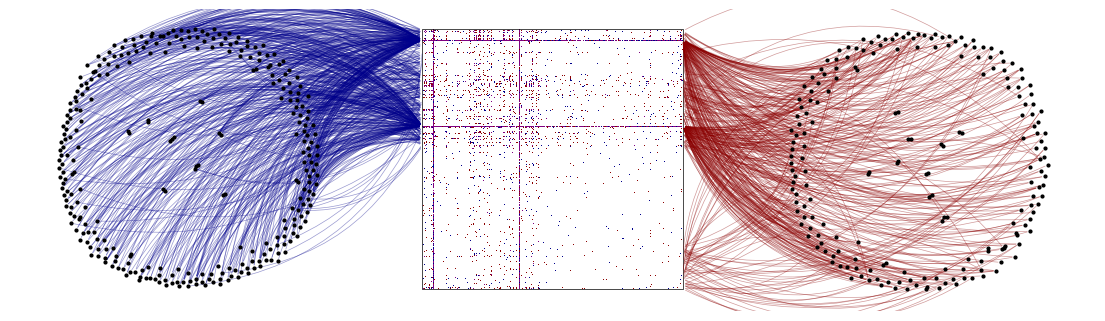

In [27]:
fig = plot_comunidades_matriz(
    nodos_comunes = nodes_intersect_11_21,
    solo_gra = nodes_only_G11,
    solo_gra1 = nodes_only_G21,
    G_unidos = G_unidos1,
    edges_only_gra = only_G11,
    edges_only_gra1 = only_G21,
    nodos_intersection = intersect_11_21
)



Redes Combinadas, con W_opt Cuántico

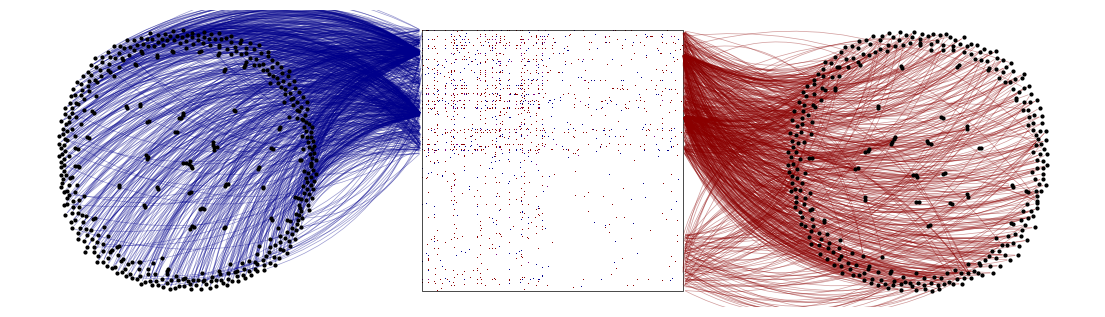

In [28]:
fig = plot_comunidades_matriz(
    nodos_comunes = nodes_intersect_12_22,
    solo_gra = nodes_only_G12,
    solo_gra1 = nodes_only_G22,
    G_unidos = G_unidos2,
    edges_only_gra = only_G12,
    edges_only_gra1 = only_G22,
    nodos_intersection = intersect_12_22
)